|       Size |   Fused Extension (ms) |   PyTorch Softmax (ms) |
|-----------:|-----------------------:|-----------------------:|
|  10000     |              0.010752  |              0.016896  |
|  50000     |              0.0812544 |              0.0165888 |
| 100000     |              0.159398  |              0.0265728 |
| 500000     |              0.78807   |              0.113715  |
|      1e+06 |              1.57317   |              0.223693  |


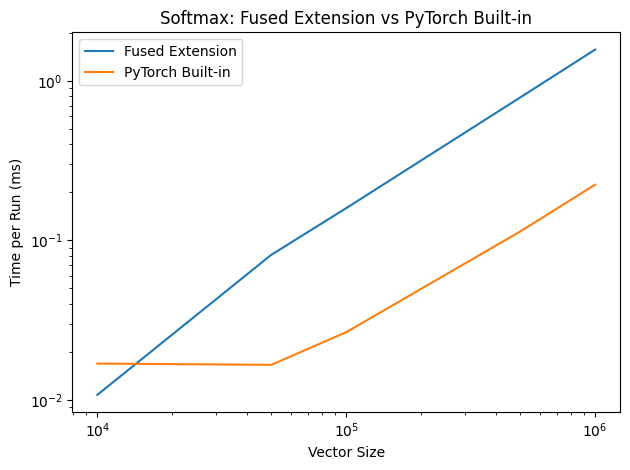

In [2]:
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
from cuda_softmax_ext import softmax_fused  # extension

device = torch.device("cuda")

# Vector sizes to test
sizes = [10_000, 50_000, 100_000, 500_000, 1_000_000]
runs = 20

results = []

# Warm up once
x_max = torch.randn(sizes[-1], device=device)
y_max = torch.empty_like(x_max)
softmax_fused(x_max, y_max)
torch.nn.functional.softmax(x_max, dim=0)

for N in sizes:
    x = torch.randn(N, device=device, dtype=torch.float32)
    y = torch.empty_like(x)

    # Warm-up
    for _ in range(5):
        softmax_fused(x, y)
        torch.nn.functional.softmax(x, dim=0)

    # Time fused extension
    torch.cuda.synchronize()
    start = torch.cuda.Event(enable_timing=True)
    end   = torch.cuda.Event(enable_timing=True)
    start.record()
    for _ in range(runs):
        softmax_fused(x, y)
    end.record()
    torch.cuda.synchronize()
    time_fused = start.elapsed_time(end) / runs  # ms per run

    # Time PyTorch built-in
    start.record()
    for _ in range(runs):
        torch.nn.functional.softmax(x, dim=0)
    end.record()
    torch.cuda.synchronize()
    time_builtin = start.elapsed_time(end) / runs

    results.append({
        "Size": N,
        "Fused Extension (ms)": time_fused,
        "PyTorch Softmax (ms)": time_builtin
    })

df = pd.DataFrame(results)

# Print results
print(df.to_markdown(index=False))

# Plot (log–log)
plt.figure()
plt.plot(df["Size"], df["Fused Extension (ms)"], label="Fused Extension")
plt.plot(df["Size"], df["PyTorch Softmax (ms)"], label="PyTorch Built-in")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Vector Size")
plt.ylabel("Time per Run (ms)")
plt.title("Softmax: Fused Extension vs PyTorch Built-in")
plt.legend()
plt.tight_layout()
plt.show()
